# Convergence 2D elasticity to beam
We investigate numerically how good the Timoschenko beam and Bernoulli beam model approximate the full 2D elasticity problem for thickness $t\to0$.

In [1]:
from ngsolve import *
from ngsolve.meshes import Make1DMesh, MakeStructured2DMesh
from ngsolve.webgui import Draw

We choose material parameters such that the elasticity tensor $\mathbb{C}$ becomes the identity. We consider a beam of length $1$ and thickness $t$, which is fixed on the left and apply a shear force at the right boundary.

In [2]:
# use material parameters such that equations simplify
mu, lam = 0.5, 0  # Lame parameter
nu = lam/(2*(lam+mu)) # Possion ratio (=0)
E = mu*(3*lam+2*mu)/(lam+mu) # Young's modulus (=1)
k = 5/6           # shear correction factor
G = E/(2*(1+nu))  # shearing modulus
force = CF( (0,-0.1) )

mesh = MakeStructured2DMesh(nx=10, ny=1, mapping=lambda x,y : (x,0.1*y))
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [3]:
def SolveTDNNS(order, mesh, t, draw=False):
    fesU = HCurl(mesh, order=order, dirichlet="left")
    fesS = HDivDiv(mesh, order=order,dirichlet="top|bottom|right")
    X = fesS*fesU
    (sigma,u),(tau,v) = X.TnT()
            
    n = specialcf.normal(2)  
    def tang(u): return u-(u*n)*n
            
    a = BilinearForm(X, symmetric=True, symmetric_storage=True)
    a += (InnerProduct(sigma,tau) + div(sigma)*v + div(tau)*u -1e-10*u*v)*dx
    a += (-(sigma*n)*tang(v) - (tau*n)*tang(u) )*dx(element_boundary=True)
    a.Assemble()
            
    f = LinearForm(X)
    f += -t**2*force*v.Trace()*ds("right")
    f.Assemble()
            
    gfsol = GridFunction(X)
    gfsigma, gfu = gfsol.components
    
    gfsol.vec.data = a.mat.Inverse(X.FreeDofs(), inverse="sparsecholesky")*f.vec
    
    if draw:
        Draw(gfu, mesh, "u", deformation=True)
    
    return gfu
t=1e-2
mesh2D = MakeStructured2DMesh(nx=10,ny=1, mapping=lambda x,y : (x,t*(y-0.5)))
gfuTDNNS = SolveTDNNS(4, t=t, mesh=mesh2D, draw=True)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [5]:
def SolveTB(order, mesh, t, reduced_integration=False, draw=False):
    V = H1(mesh, order=order, dirichlet="left")
    fes = V*V    
    (u,beta),(du,dbeta) = fes.TnT()
    
    a = BilinearForm(fes, symmetric=True)
    a += 1/12*grad(beta)*grad(dbeta)*dx + k*G/t**2*(grad(u)-beta)*(grad(du)-dbeta)*dx(bonus_intorder=-reduced_integration)
    
    f = LinearForm(fes)
    f += force[1]*du*ds("right")
    
    gfsol = GridFunction(fes)
    
    a.Assemble()
    f.Assemble()
    gfsol.vec.data = a.mat.Inverse(fes.FreeDofs(),inverse="sparsecholesky")*f.vec
    gfu, gfbeta = gfsol.components
    
    if draw:
        Draw(gfu,mesh, deformation=CF((0,gfu,0)))
    
    return gfu, gfbeta

mesh1D = Make1DMesh(20)

gfuTB, gfbetaTB = SolveTB(order=3, mesh=mesh1D, t=t, draw=True)

def SolveBB(order, mesh, draw=False):
    fes = H1(mesh, order=order, dirichlet="left")*H1(mesh, order=order, dirichlet="right")#"left"
    (u,sigma),(du,dsigma) = fes.TnT()
    
    a = BilinearForm(fes, symmetric=True)
    a += (12*sigma*dsigma + grad(u)*grad(dsigma) + grad(du)*grad(sigma))*dx
    
    f = LinearForm(fes)
    f += -force[1]*du*ds("right")
    
    gfsol = GridFunction(fes)
    
    a.Assemble()
    f.Assemble()
    gfsol.vec.data = a.mat.Inverse(fes.FreeDofs(),inverse="umfpack")*f.vec
    
    if draw:
        Draw(gfsol.components[0],mesh, deformation=CF((0,gfsol.components[0],0)))
    return gfsol.components[0]

gfuBB = SolveBB(order=3, mesh=Make1DMesh(20), draw=True)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

Now we solve the 2D elasticity and Timoschenko beam problem for different thicknesses $t$ (the Bernoulli beam is independent of $t$ and gets thus only solved once) and compute the relative error of the beam models with respect to the 2D elasticity solution by comparing the vertical deflection at the midsurface at the right boundary.

In [6]:
l = []
gfwBB = SolveBB(order=4, mesh=Make1DMesh(20))
gfuBB = CF( (-y*Grad(gfwBB), gfwBB) )
with TaskManager():
    for t in [10**(-i) for i in range(6)]:
        mesh2D = MakeStructured2DMesh(nx=int(30/t**0.25),ny=1, mapping=lambda x,y : (x,t*(y-0.5)))
        gfuTDNNS = SolveTDNNS(2,t=t,mesh=mesh2D)
        l2TDNNS = sqrt(Integrate(gfuTDNNS*gfuTDNNS,mesh2D))
        gfwTB, gfbetaTB = SolveTB(order=4, mesh=Make1DMesh(20), t=t)
        gfuTB = CF( (y*gfbetaTB,gfwTB) )
        l.append((t, sqrt(Integrate((gfuTDNNS-gfuTB)**2,mesh2D,order=10))/l2TDNNS, \
                  sqrt(Integrate((gfuTDNNS-gfuBB)**2,mesh2D,order=10))/l2TDNNS))

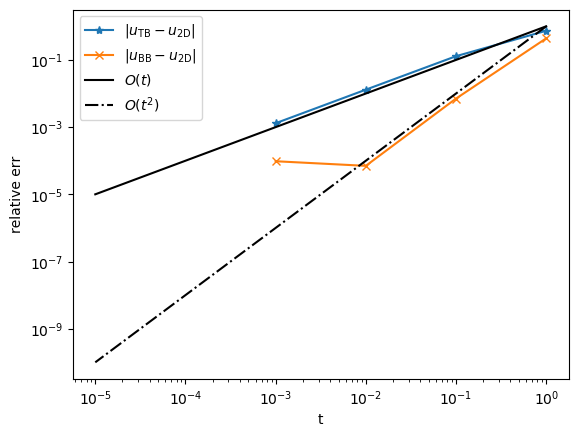

In [7]:
import matplotlib.pyplot as plt
plt.yscale('log')
plt.xscale('log')
plt.xlabel("t")
plt.ylabel("relative err")
ts,errtb,errbb = zip(*l)
plt.plot(ts, errtb, '*-', label="$|u_{\mathrm{TB}}-u_{\mathrm{2D}}|$")
plt.plot(ts, errbb, 'x-', label="$|u_{\mathrm{BB}}-u_{\mathrm{2D}}|$")
plt.plot(ts, [th for th in ts], '-' , color="k", label="$O(t)$")
plt.plot(ts, [th**2 for th in ts], '-.' , color="k", label="$O(t^2)$")
plt.legend()
plt.show()